<a href="https://colab.research.google.com/github/kennardmah/classification-cyberbullying/blob/main/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install emoji

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from gensim.models import Word2Vec
from imblearn.over_sampling import RandomOverSampler
import re
import string
import emoji
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 8.0 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Preprocessing functions
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

def remove_emojis(text):
    text = emoji.demojize(text)
    return text.replace(':', ' ')

def remove_urls(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def remove_html(text):
    return re.sub(r'<.*?>', '', text)

def remove_punctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return ' '.join(word for word in text.split() if word.lower() not in stop_words)

def preprocess_text(text):
    text = remove_emojis(text)
    text = remove_urls(text)
    text = remove_html(text)
    text = remove_punctuations(text)
    text = remove_stopwords(text)
    return text

# Load and preprocess data
data_path = '/content/drive/MyDrive/ADL/PAPER/cyberbullying_tweets.csv.zip'
df = pd.read_csv(data_path)
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})
df = df.drop_duplicates()
df['sentiment'] = df['sentiment'].replace(['other_cyberbullying'], 'other')
df['sentiment'] = df['sentiment'].replace(['not_cyberbullying'], 'none')

# Preprocess text
df['text'] = df['text'].apply(preprocess_text)
df['tweet_length'] = df['text'].apply(lambda x: len(x.split()))

df = df[df['tweet_length'] <= 30]
df.drop('tweet_length', axis=1, inplace=True)

<ipython-input-9-abbdae5bc8df>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('tweet_length', axis=1, inplace=True)


In [10]:
# Tokenization
def Tokenize(df, max_length):
    corpus = df['text'].str.cat(sep=' ').split()
    count_words = Counter(corpus)
    vocab_to_int = {w: i + 1 for i, (w, _) in enumerate(count_words.most_common())}
    token_ids = [[vocab_to_int.get(word, 0) for word in text.split()] for text in df['text']]
    token_ids = [ids[:max_length] + [0] * (max_length - len(ids)) for ids in token_ids]
    return torch.tensor(token_ids), vocab_to_int

labels = df['sentiment'].map({'none': 0, 'gender': 1, 'religion': 2, 'ethnicity': 3, 'age': 4, 'other': 5}).values
labels = torch.tensor(labels)

token_ids, vocab_to_int = Tokenize(df, max_length=30)

In [11]:
# Word2Vec embedding
word2vec_model = Word2Vec([text.split() for text in df['text']], vector_size=100)
embedding_matrix = np.zeros((len(vocab_to_int) + 1, 100))
for word, i in vocab_to_int.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(token_ids, labels, test_size=0.4, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

# Oversample training data
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(X_train.numpy(), y_train.numpy())
X_train, y_train = torch.tensor(X_train), torch.tensor(y_train)

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
valid_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=16)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=16)

In [12]:
# Define LSTM model with attention
class Attention(nn.Module):
    def __init__(self, hidden_dim, bidirectional):
        super().__init__()
        self.attention = nn.Linear(hidden_dim * (2 if bidirectional else 1), 1)

    def forward(self, lstm_output):
        weights = torch.softmax(self.attention(lstm_output), dim=1)
        context = torch.sum(weights * lstm_output, dim=1)
        return context

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.attention = Attention(hidden_dim, bidirectional)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        lstm_output, _ = self.lstm(embedded)
        context = self.attention(lstm_output)
        return self.fc(context)



In [13]:
# Initialize model
model = LSTMClassifier(len(vocab_to_int) + 1, 100, 128, len(df['sentiment'].unique()), 2, True, 0.5, 0)
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=10):
    best_val_loss = float('inf')
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss, correct_train = 0, 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()

        model.eval()
        valid_loss, correct_val = 0, 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                correct_val += (outputs.argmax(1) == labels).sum().item()

        print(f"Epoch {epoch+1}/{epochs}: Train Loss={train_loss/len(train_loader):.4f}, Train Acc={correct_train/len(train_loader.dataset):.4f}, Val Loss={valid_loss/len(valid_loader):.4f}, Val Acc={correct_val/len(valid_loader.dataset):.4f}")

        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            torch.save(model.state_dict(), 'best_model.pth')

train_model(model, train_loader, valid_loader, criterion, optimizer)

Epoch 1/10: Train Loss=0.5857, Train Acc=0.7558, Val Loss=0.4771, Val Acc=0.7880
Epoch 2/10: Train Loss=0.3111, Train Acc=0.8802, Val Loss=0.4560, Val Acc=0.8193
Epoch 3/10: Train Loss=0.1490, Train Acc=0.9439, Val Loss=0.5908, Val Acc=0.8027
Epoch 4/10: Train Loss=0.0899, Train Acc=0.9589, Val Loss=0.7535, Val Acc=0.7960
Epoch 5/10: Train Loss=0.0675, Train Acc=0.9662, Val Loss=0.8721, Val Acc=0.7909
Epoch 6/10: Train Loss=0.0572, Train Acc=0.9695, Val Loss=1.0147, Val Acc=0.7904
Epoch 7/10: Train Loss=0.0512, Train Acc=0.9706, Val Loss=1.0632, Val Acc=0.7828
Epoch 8/10: Train Loss=0.0477, Train Acc=0.9731, Val Loss=1.0556, Val Acc=0.7805
Epoch 9/10: Train Loss=0.0436, Train Acc=0.9736, Val Loss=1.2416, Val Acc=0.7809
Epoch 10/10: Train Loss=0.0432, Train Acc=0.9733, Val Loss=1.2470, Val Acc=0.7768


In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

<ipython-input-19-9de4b5444c5b>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
100%|██████████| 581/581 [00:08<00:00, 6

              precision    recall  f1-score   support

           0       0.58      0.55      0.57      1587
           1       0.83      0.89      0.86      1548
           2       0.93      0.95      0.94      1519
           3       0.96      0.97      0.96      1528
           4       0.96      0.97      0.96      1541
           5       0.64      0.61      0.62      1563

    accuracy                           0.82      9286
   macro avg       0.82      0.82      0.82      9286
weighted avg       0.82      0.82      0.82      9286

Test Loss=0.4605, Test Acc=0.8206


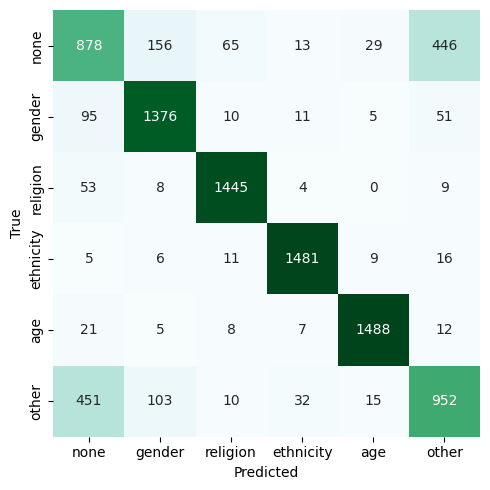

In [19]:
# Evaluate on test set
def evaluate_model(model, test_loader):
    all_preds = []
    all_labels = []
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            correct += (outputs.argmax(1) == labels).sum().item()
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print(classification_report(all_labels, all_preds))
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(df['sentiment'].unique())))
    print(f"Test Loss={test_loss/len(test_loader):.4f}, Test Acc={correct/len(test_loader.dataset):.4f}")
    # Plot the confusion matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='BuGn', cbar=False,
                xticklabels=['none', 'gender', 'religion', 'ethnicity', 'age', 'other'],
                yticklabels=['none', 'gender', 'religion', 'ethnicity', 'age', 'other'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

evaluate_model(model, test_loader)

In [ ]:
# plot evaluation
train_losses = []  # Store training loss after each epoch
val_losses = []    # Store validation loss after each epoch
# Add these lists into your training loop and update each epoch:
# train_losses.append(train_loss / len(train_loader))
# val_losses.append(valid_loss / len(valid_loader))

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Collect true and predicted labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds, labels=range(len(df['sentiment'].unique())))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df['sentiment'].unique())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
